# Agglomerative Clustering

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [3]:
from itertools import combinations

for x in combinations([1,2,3,4,5], r=2):
    print(x)

(1, 2)
(1, 3)
(1, 4)
(1, 5)
(2, 3)
(2, 4)
(2, 5)
(3, 4)
(3, 5)
(4, 5)


In [4]:
import numpy as np
import pandas as pd
from itertools import combinations

class agglomerative_clustering:
    
    def __init__(self, linkage="average", n_clusters=5, max_dist=None):
        """
        """
        self.link = linkage
        self.clusters = {}
        self.n_clusters = n_clusters
        if max_dist:
            self.max_dist = max_dist
        self.merge_tracker = []
        self.data = None
        self.labels = None

    def euclidean_distance(self, pt1, pt2):
        """
        Returns the distance. Currently only uses Euclidean distance.
        ---
        Input: Cluster (cluster object), data point (np array)
        Output: Distance (float)
        """
        return np.sqrt(np.sum((pt1 - pt2)**2))
       
    def compute_distance(self, idx1, idx2):
        if self.link == 'average':
            return self.euclidean_distance(self.clusters[idx1]['mean'], self.clusters[idx2]['mean'])
        elif self.link == 'complete':
            return self.complete_linkage(idx1, idx2)
        elif self.link == 'minimal':
            return self.minimal_linkage(idx1, idx2)
        elif self.link == 'ward':
            return self.ward_linkage(idx1, idx2)
        else:
            raise TypeError("Not a proper linkage function selection!")
        
    def complete_linkage(self, idx1, idx2):
        max_dist = 0.
        for pt in self.clusters[idx1]['members']:
            for pt2 in self.clusters[idx2]['members']:
                dist = self.euclidean_distance(self.data[pt], self.data[pt2])
                if dist > max_dist:
                    max_dist = dist
        return max_dist
    
    def minimal_linkage(self, idx1, idx2):
        min_dist = 99999999.
        for pt in self.clusters[idx1]['members']:
            for pt2 in self.clusters[idx2]['members']:
                dist = self.euclidean_distance(self.data[pt], self.data[pt2])
                if dist < min_dist:
                    min_dist = dist
        return min_dist
    
    def ward_linkage(self, idx1, idx2):
        inertia_1 = 0
        inertia_2 = 0
        inertia_combined = 0
        
        for pt in self.clusters[idx1]['members']:
            inertia_1 += self.euclidean_distance(self.data[pt], self.clusters[idx1]['mean'])
        for pt in self.clusters[idx2]['members']:
            inertia_2 += self.euclidean_distance(self.data[pt], self.clusters[idx2]['mean'])
            
        combined_members = self.clusters[idx1]['members'] + self.clusters[idx2]['members']
        combined_mean = np.mean([X[i] for i in combined_members], axis=0)
        
        for pt in combined_members:
            inertia_combined += self.euclidean_distance(self.data[pt], combined_mean)
            
        return inertia_combined - inertia_1 - inertia_2
        
    def init_clusters(self, X):
        """
        Create a lookup table where each point is its own cluster.
        As we merge clusters, we'll remove members and track the progress
        with this dictionary.
        """
        for idx, pt in enumerate(X):
            self.clusters[idx] = {'members': [idx], 'mean': pt}
        self.data = X
            
    def merge_clusters(self, idx1, idx2, distance):
        self.clusters[idx1]['members'] += self.clusters[idx2]['members']
        self.clusters[idx1]['mean'] = np.mean([X[i] for i in self.clusters[idx1]['members']], axis=0)
        self.clusters.pop(idx2, None)
        self.merge_tracker.append((idx1, idx2, distance))
    
    def fit(self, X):
        """
        Initializes clusters, then moves the mean of the cluster to the center of
        all points in the cluster. Reassigns all points to their new 'nearest' cluster
        and repeats this process until no more assignments can occur (or too many iterations).
        Whole procedure is repeated n_init times, to overcome local minima. Only the best 
        clustering is kept as part of the model.
        ---
        Input: X (data, array/dataframe)
        """
        X = self.convert_to_array(X)
        self.init_clusters(X)
        
        while len(self.clusters.keys()) > self.n_clusters:
            decision_tracker = {}
            for combo in combinations(self.clusters.keys(), r=2):
                decision_tracker[combo] = self.compute_distance(combo[0], combo[1])
            to_merge = sorted(decision_tracker.items(), key=lambda x: x[1])[0][0]
            self.merge_clusters(to_merge[0], to_merge[1], decision_tracker[combo])
            #print(to_merge, self.merge_tracker)
        
        self.labels = np.zeros(X.shape[0])
        for ix, clst in enumerate(self.clusters.keys()):
            members = self.clusters[clst]['members']
            self.labels[members] = ix
    
    def fit_predict(self,X):
        """
        Creates clusters for data X, and returns cluster ID's for each point.
        ---
        Input: X (data, array)
        Output: cluster IDs for X (array)
        """
        self.fit(X)
        return self.labels
    
    def pandas_to_numpy(self, x):
        """
        Checks if the input is a Dataframe or series, converts to numpy matrix for
        calculation purposes.
        ---
        Input: X (array, dataframe, or series)
        Output: X (array)
        """
        if type(x) == type(pd.DataFrame()) or type(x) == type(pd.Series()):
            return x.as_matrix()
        if type(x) == type(np.array([1,2])):
            return x
        return np.array(x) 
    
    def handle_1d_data(self,x):
        """
        Converts 1 dimensional data into a series of rows with 1 columns
        instead of 1 row with many columns.
        """
        if x.ndim == 1:
            x = x.reshape(-1,1)
        return x
    
    def convert_to_array(self, x):
        """
        Takes in an input and converts it to a numpy array
        and then checks if it needs to be reshaped for us
        to use it properly
        """
        x = self.pandas_to_numpy(x)
        x = self.handle_1d_data(x)
        return x
    

In [5]:
def get_data(n_clust = 3, pts_per_clst=10):
    X1 = np.random.normal(-5,1,pts_per_clst).reshape(-1,1)
    y1 = np.random.normal(-5,1,pts_per_clst).reshape(-1,1)
    for _ in range(n_clust-1):
        X2 = np.random.normal(np.random.randint(-10,10),1,pts_per_clst).reshape(-1,1)
        y2 = np.random.normal(np.random.randint(-10,10),1,pts_per_clst).reshape(-1,1)
        X1 = np.vstack((X1,X2)).reshape(-1,1)
        y1 = np.vstack((y1,y2)).reshape(-1,1)
    X = np.hstack((X1,y1))
    return X
np.random.seed(1234)
X = get_data(n_clust=5)

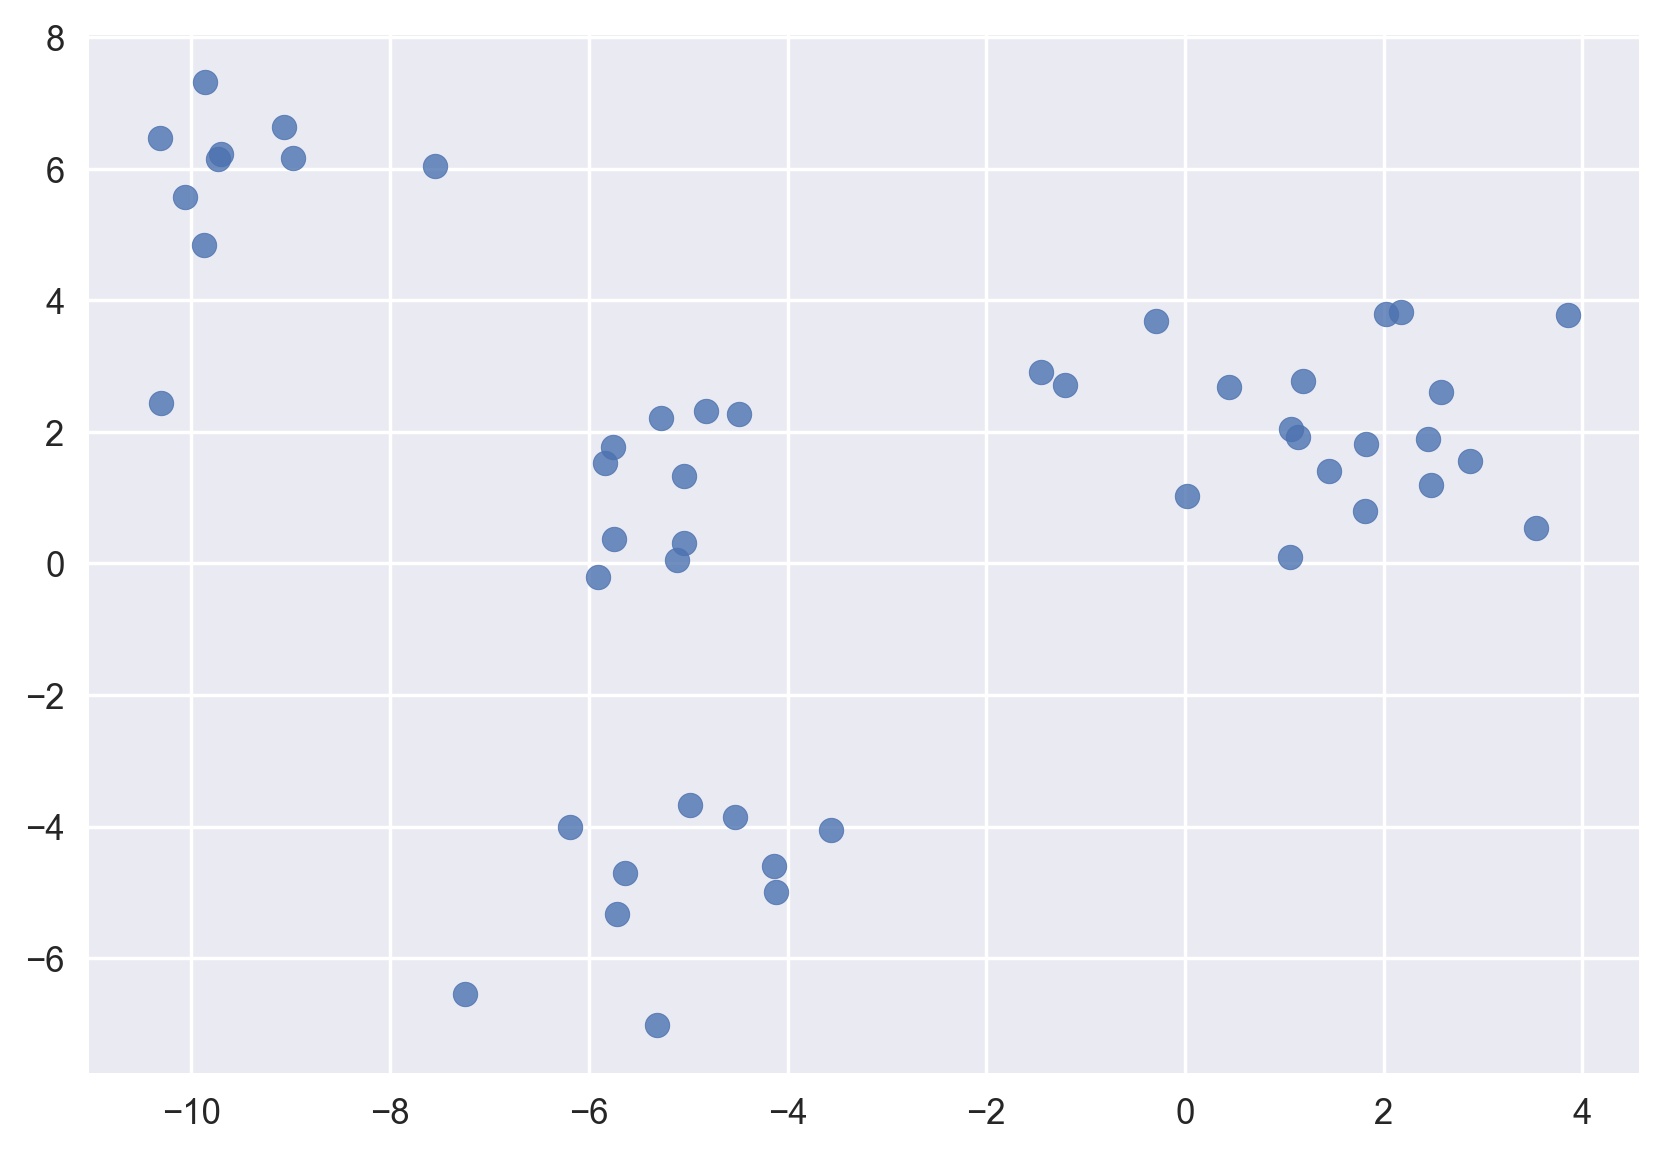

In [6]:
plt.figure(dpi=250)
plt.scatter(X[:,0],X[:,1], alpha=0.8);

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  4.
  3.  3.  3.  3.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


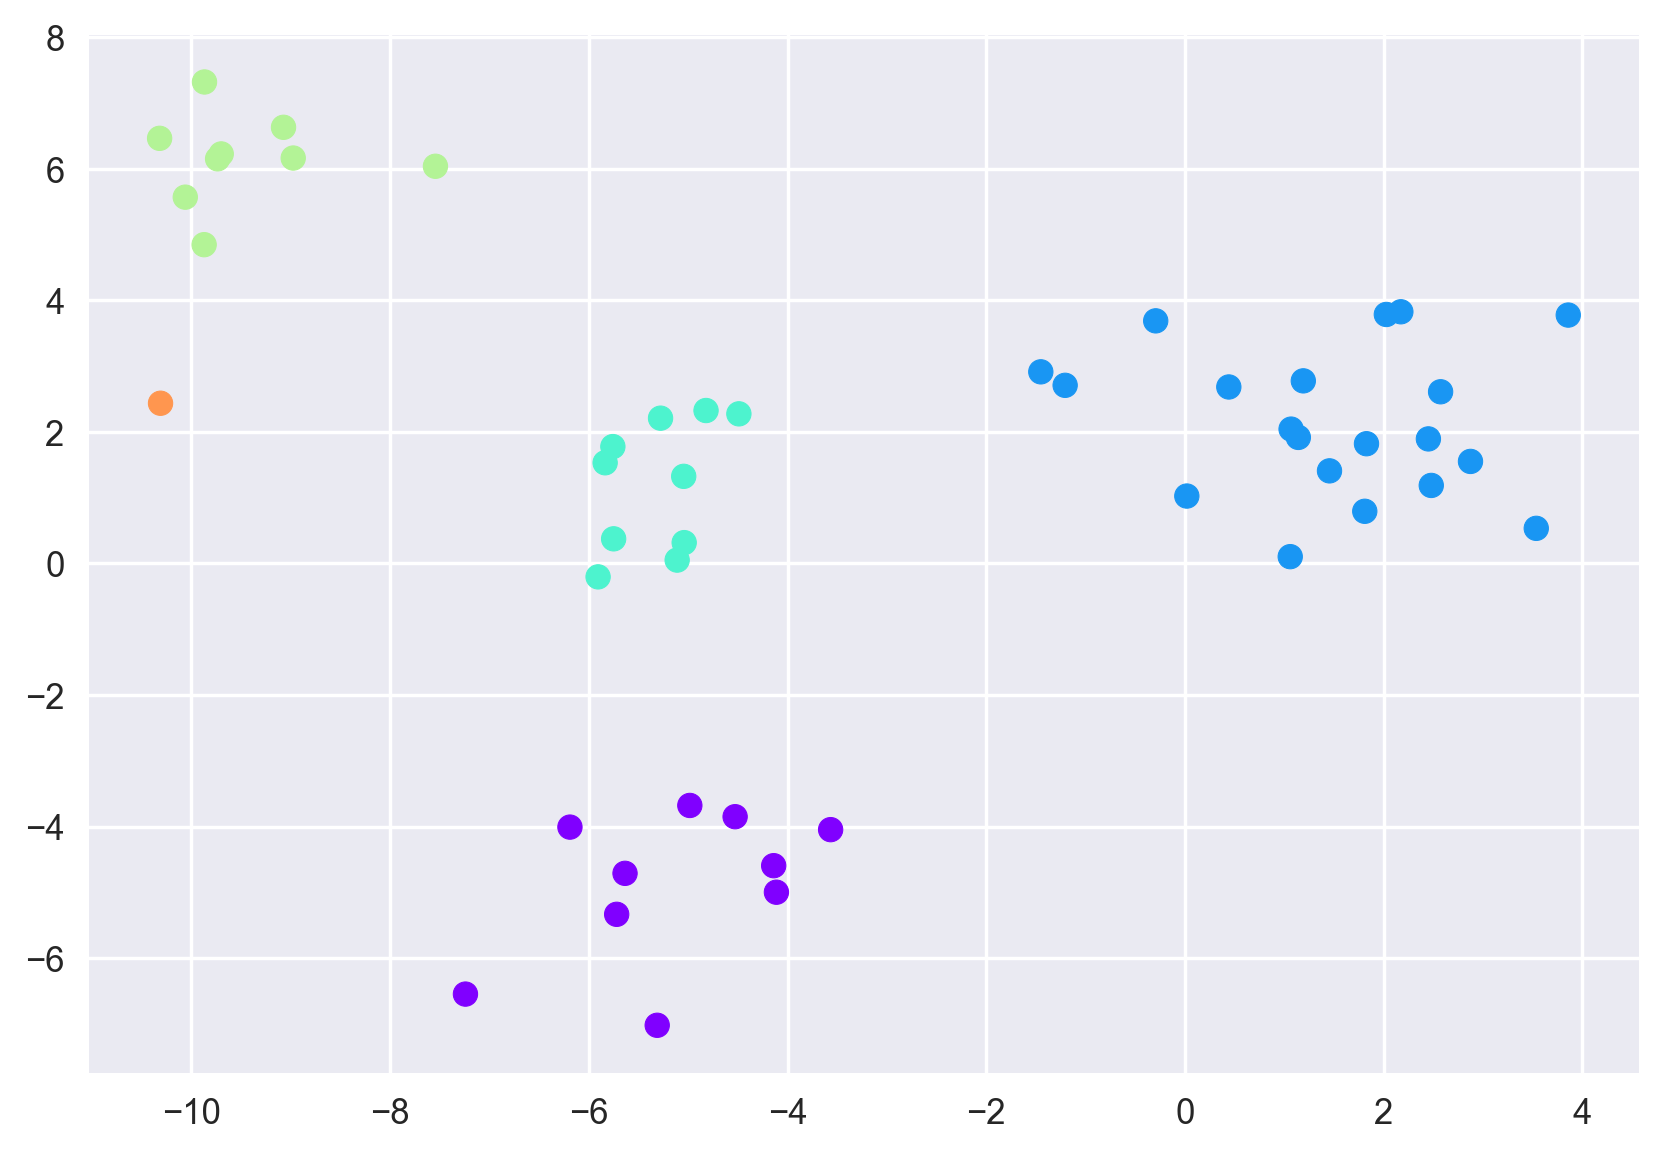

In [7]:
ac = agglomerative_clustering(linkage='average')
ac.fit(X)

print(ac.labels)

plt.figure(dpi=250)
plt.scatter(X[:,0], X[:,1], c=plt.cm.rainbow(0.2*ac.labels));

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  2.  1.  1.  1.  1.  1.
  1.  1.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  2.  1.  2.  1.  2.  2.  2.  2.  2.  1.]


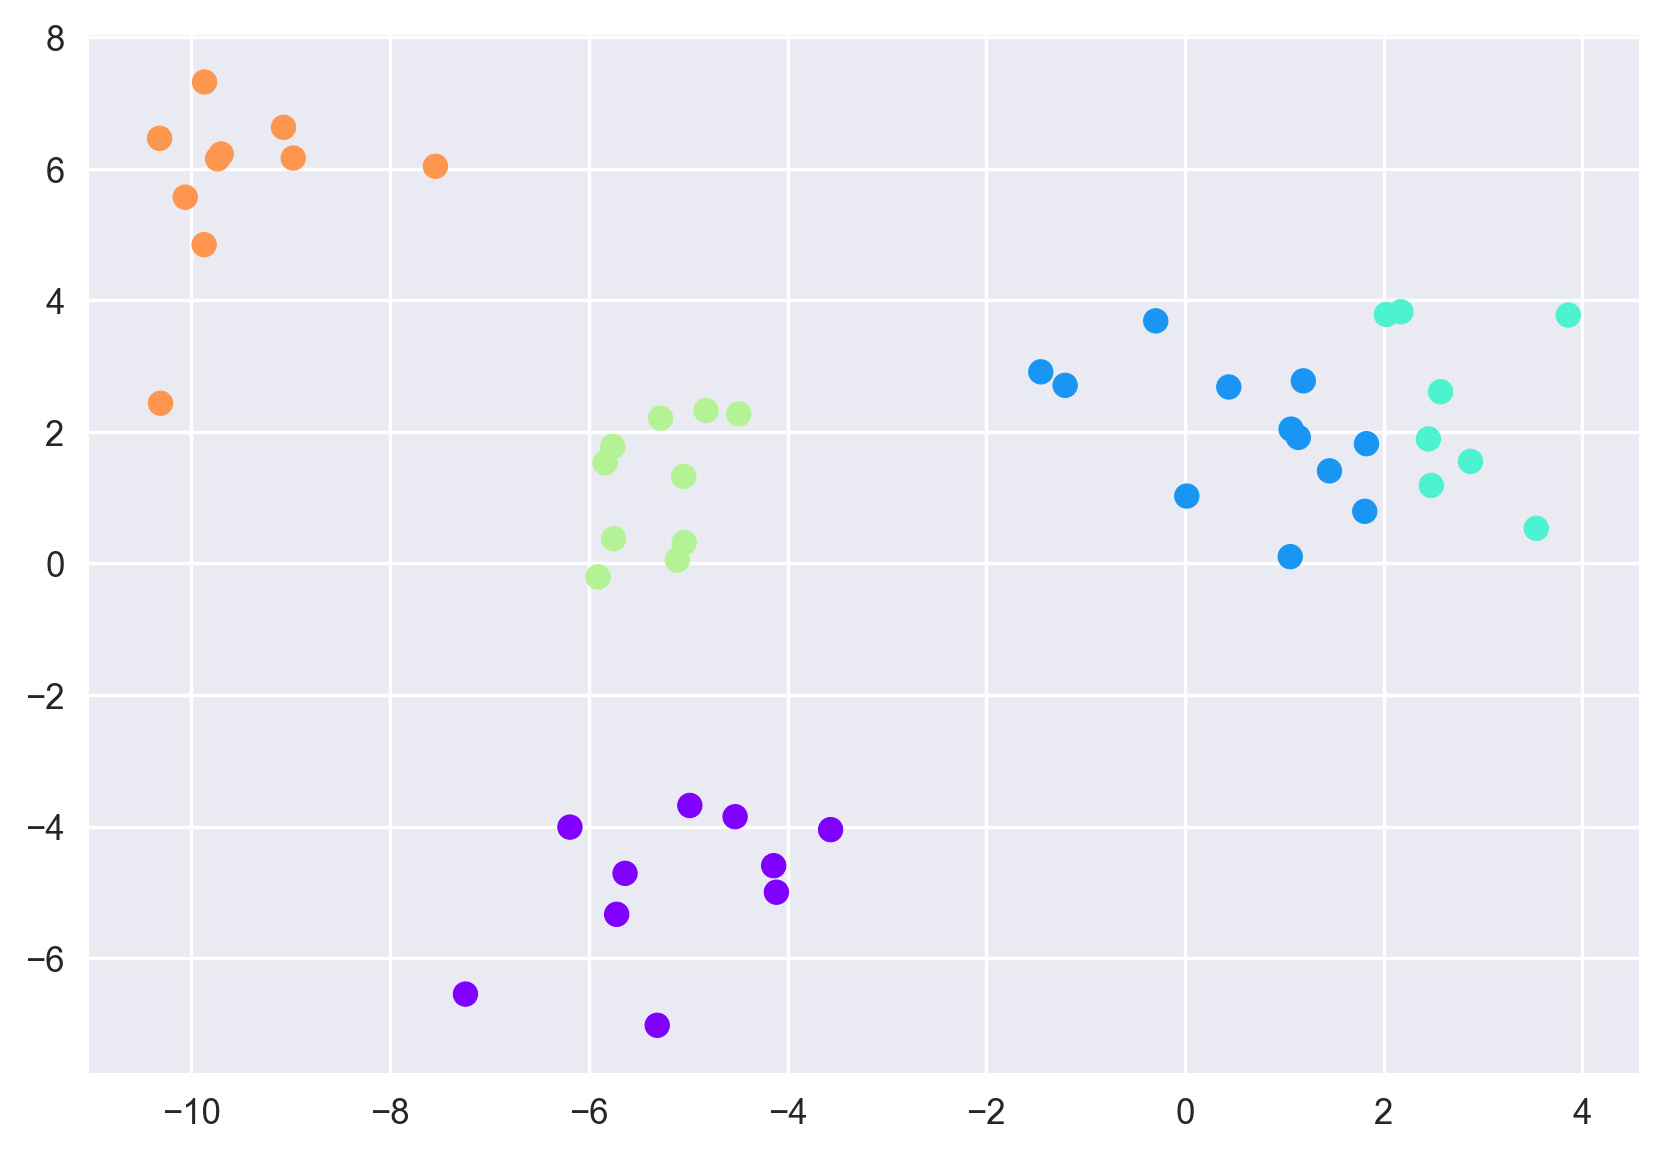

In [8]:
ac2 = agglomerative_clustering(linkage='complete')
print(ac2.fit_predict(X))

plt.figure(dpi=250)
plt.scatter(X[:,0], X[:,1], c=plt.cm.rainbow(0.2*ac2.labels));

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  4.
  3.  3.  3.  3.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


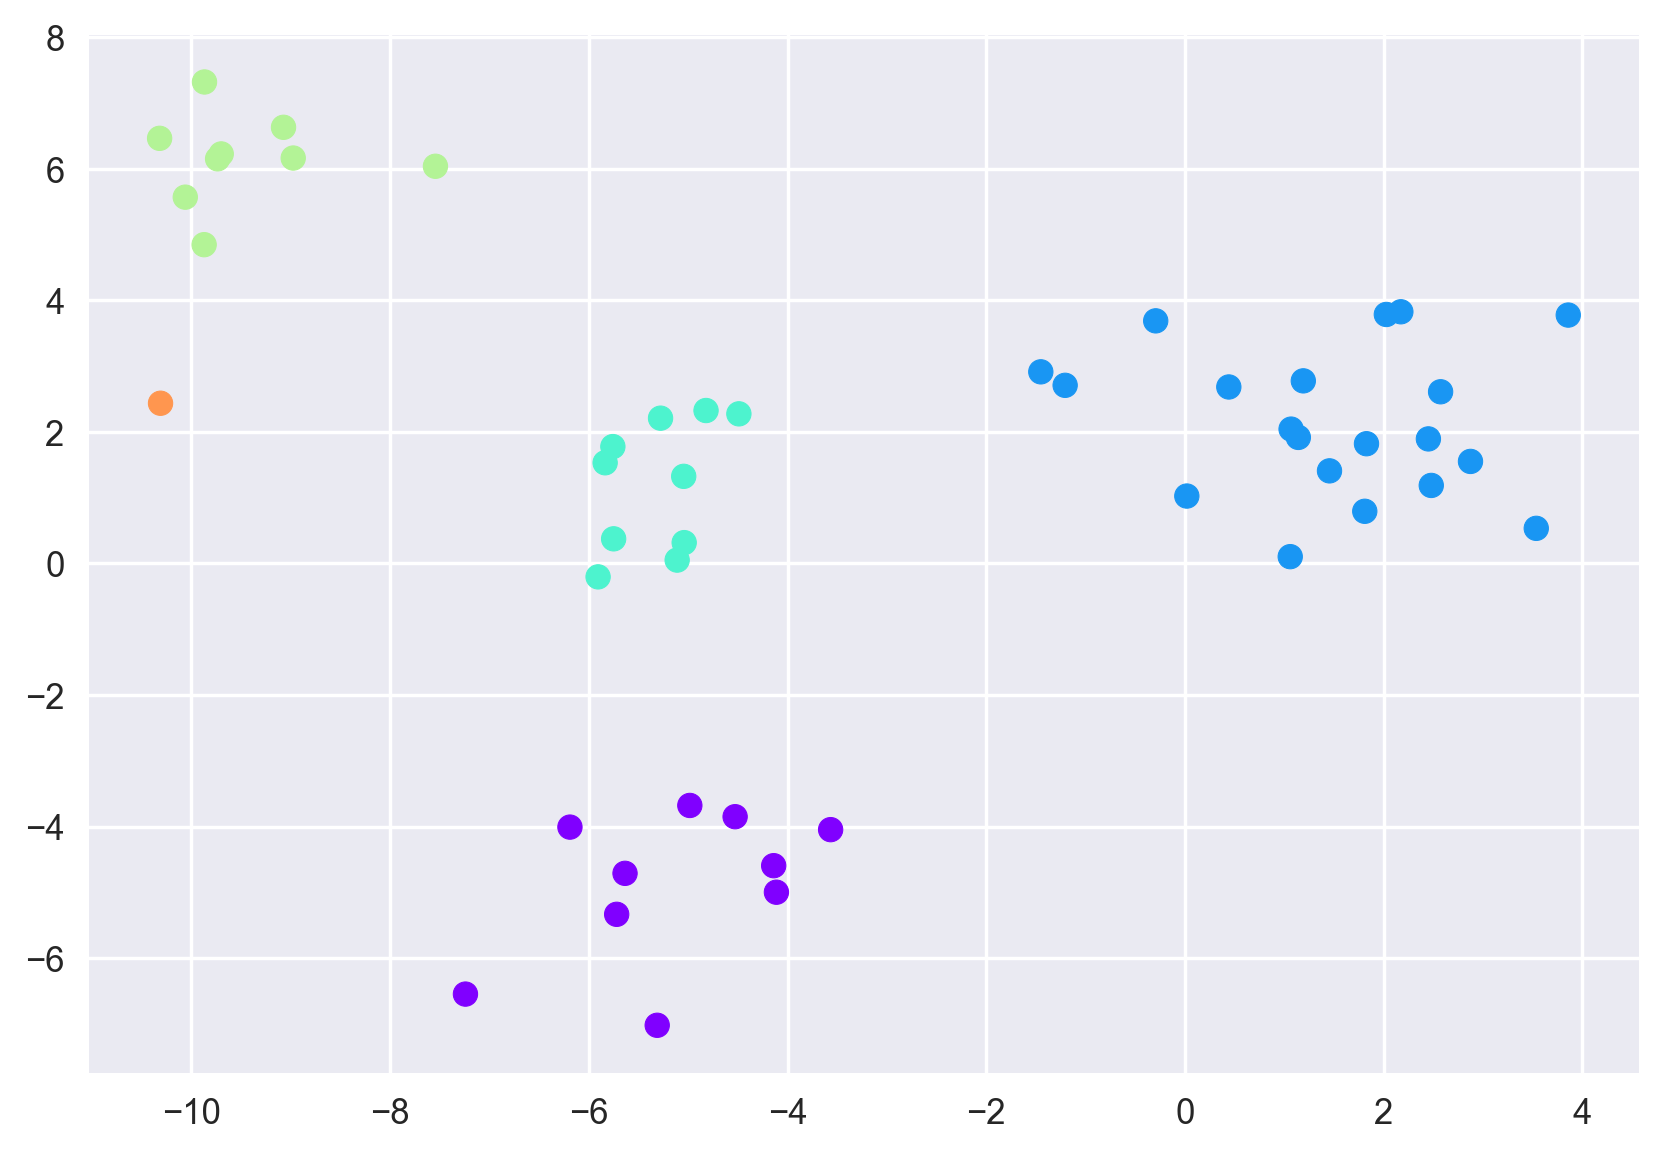

In [9]:
ac3 = agglomerative_clustering(linkage='minimal')
print(ac3.fit_predict(X))

plt.figure(dpi=250)
plt.scatter(X[:,0], X[:,1], c=plt.cm.rainbow(0.2*ac3.labels));

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  1.  1.  2.  2.  1.  1.
  1.  1.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


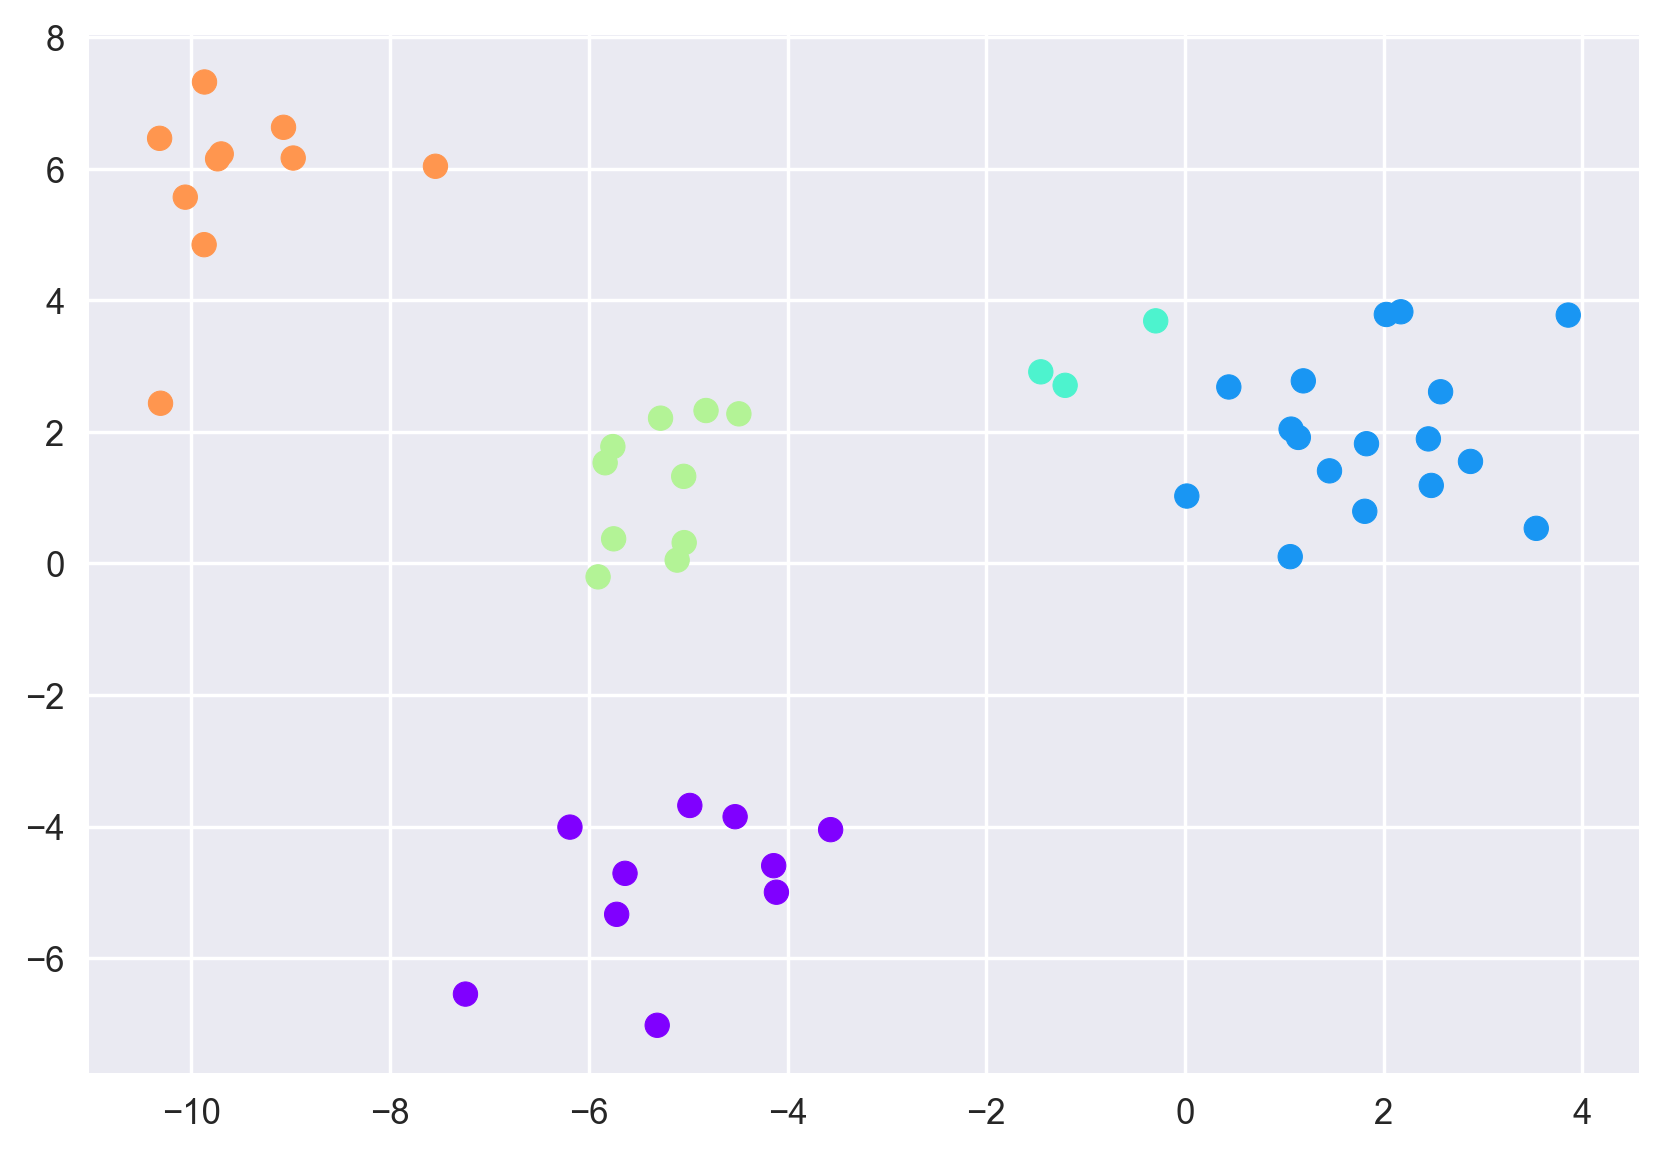

In [10]:
ac4 = agglomerative_clustering(linkage='ward')
print(ac4.fit_predict(X))

plt.figure(dpi=250)
plt.scatter(X[:,0], X[:,1], c=plt.cm.rainbow(0.2*ac4.labels));

## Test in 3D

In [11]:
def get_multidim_data(n_clust = 3, num_dim=3, pt_per_clst=20):
    X = np.random.normal(-5,1,size=(pt_per_clst,3))

    for _ in range(n_clust-1):
        X2 = np.random.normal(np.random.randint(-10,10),1,size=(pt_per_clst,3))
        X = np.vstack((X,X2))
    return X

X = get_multidim_data(n_clust=5)

In [12]:
ac = agglomerative_clustering(linkage='ward')
ac.fit_predict(X)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

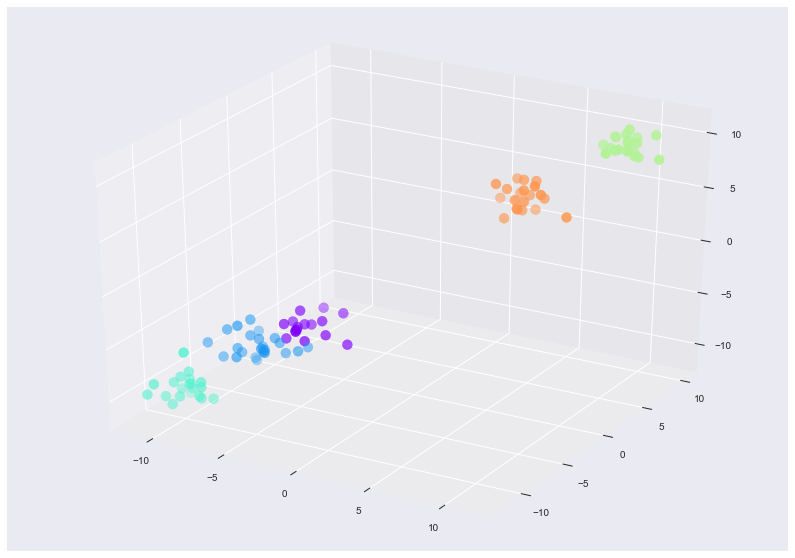

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,10))
ax = fig.gca(projection='3d')
ax.scatter(X[:,0],X[:,1], X[:,2], c=plt.cm.rainbow(0.2*ac.labels), s=100);

In [14]:
%%timeit

ac = agglomerative_clustering(linkage='ward')
ac.fit_predict(X)

11 s ± 2.07 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit

ac = agglomerative_clustering(linkage='average')
ac.fit_predict(X)

1.06 s ± 45.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%timeit

ac = agglomerative_clustering(linkage='complete')
ac.fit_predict(X)

3.06 s ± 48.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
